In [ ]:
!git clone https://github.com/One-2-3-45/One-2-3-45.git

Cloning into 'One-2-3-45'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 301 (delta 29), reused 38 (delta 16), pack-reused 243
Receiving objects: 100% (301/301), 6.35 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
%cd /content/One-2-3-45/

/content/One-2-3-45


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install inplace_abn

Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git#egg=taming-transformers (from -r requirements.txt (line 22))
  Updating ./src/taming-transformers clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 3ba01b241669f5ade541ce990f7650a3b8f65318
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/NVlabs/nvdiffrast.git to /tmp/pip-req-build-mqus66vk
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast.git /tmp/pip-req-build-mqus66vk
  Resolved https://github.com/NVlabs/nvdiffrast.git to commit c5caf7bdb8a2448acc491a9faa47753972edd380
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_375nhs6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_375nhs6
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Prepa

In [ ]:
import os
import torch
from PIL import Image
from utils.zero123_utils import init_model, predict_stage1_gradio, zero123_infer
from utils.sam_utils import sam_init, sam_out_nosave
from utils.utils import pred_bbox, image_preprocess_nosave, gen_poses, image_grid, convert_mesh_format
from elevation_estimate.estimate_wild_imgs import estimate_elev

_GPU_INDEX = 0
_HALF_PRECISION = True
_MESH_RESOLUTION = 256
# NOTE: Uncomment the following line in the docker container
# os.chdir("./One-2-3-45/")


2023-12-14 00:58:16.893552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 00:58:16.893616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 00:58:16.893651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 00:58:18.865272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!python download_ckpt.py

Downloading: 100%|█████████████████████████████████████████████| 2.56G/2.56G [01:03<00:00, 40.6MB/s]
Checkpoint downloaded and saved to: sam_vit_h_4b8939.pth
Downloading: 100%|█████████████████████████████████████████████| 15.5G/15.5G [06:33<00:00, 39.3MB/s]
Checkpoint downloaded and saved to: zero123-xl.ckpt
Downloading: 100%|█████████████████████████████████████████████| 46.4M/46.4M [00:02<00:00, 20.9MB/s]
Checkpoint downloaded and saved to: elevation_estimate/utils/weights/indoor_ds_new.ckpt
Downloading: 100%|█████████████████████████████████████████████| 5.31M/5.31M [00:00<00:00, 20.8MB/s]
Checkpoint downloaded and saved to: reconstruction/exp/lod0/checkpoints/ckpt_215000.pth


In [ ]:
def preprocess(predictor, raw_im, lower_contrast=False):
    raw_im.thumbnail([512, 512], Image.Resampling.LANCZOS)
    image_sam = sam_out_nosave(predictor, raw_im.convert("RGB"), pred_bbox(raw_im))
    input_256 = image_preprocess_nosave(image_sam, lower_contrast=lower_contrast, rescale=True)
    torch.cuda.empty_cache()
    return input_256

In [ ]:
def stage1_run(model, device, exp_dir,
               input_im, scale, ddim_steps):
    # folder to save the stage 1 images
    stage1_dir = os.path.join(exp_dir, "stage1_8")
    os.makedirs(stage1_dir, exist_ok=True)

    # stage 1: generate 4 views at the same elevation as the input
    output_ims = predict_stage1_gradio(model, input_im, save_path=stage1_dir, adjust_set=list(range(4)), device=device, ddim_steps=ddim_steps, scale=scale)

    # stage 2 for the first image
    # infer 4 nearby views for an image to estimate the polar angle of the input
    stage2_steps = 50 # ddim_steps
    zero123_infer(model, exp_dir, indices=[0], device=device, ddim_steps=stage2_steps, scale=scale)
    # estimate the camera pose (elevation) of the input image.
    try:
        polar_angle = int(estimate_elev(exp_dir))
    except:
        print("Failed to estimate polar angle")
        polar_angle = 90
    print("Estimated polar angle:", polar_angle)
    gen_poses(exp_dir, polar_angle)

    # stage 1: generate another 4 views at a different elevation
    if polar_angle <= 75:
        output_ims_2 = predict_stage1_gradio(model, input_im, save_path=stage1_dir, adjust_set=list(range(4,8)), device=device, ddim_steps=ddim_steps, scale=scale)
    else:
        output_ims_2 = predict_stage1_gradio(model, input_im, save_path=stage1_dir, adjust_set=list(range(8,12)), device=device, ddim_steps=ddim_steps, scale=scale)
    torch.cuda.empty_cache()
    return 90-polar_angle, output_ims+output_ims_2

def stage2_run(model, device, exp_dir,
               elev, scale, stage2_steps=50):
    # stage 2 for the remaining 7 images, generate 7*4=28 views
    if 90-elev <= 75:
        zero123_infer(model, exp_dir, indices=list(range(1,8)), device=device, ddim_steps=stage2_steps, scale=scale)
    else:
        zero123_infer(model, exp_dir, indices=list(range(1,4))+list(range(8,12)), device=device, ddim_steps=stage2_steps, scale=scale)

def reconstruct(exp_dir, output_format=".ply", device_idx=0):
    exp_dir = os.path.abspath(exp_dir)
    main_dir_path = os.path.abspath(os.path.dirname("./"))
    os.chdir('reconstruction/')

    bash_script = f'CUDA_VISIBLE_DEVICES={device_idx} python exp_runner_generic_blender_val.py \
                    --specific_dataset_name {exp_dir} \
                    --mode export_mesh \
                    --conf confs/one2345_lod0_val_demo.conf \
                    --resolution {_MESH_RESOLUTION}'
    print(bash_script)
    os.system(bash_script)
    os.chdir(main_dir_path)

    ply_path = os.path.join(exp_dir, f"mesh.ply")
    if output_format == ".ply":
        return ply_path
    if output_format not in [".obj", ".glb"]:
        print("Invalid output format, must be one of .ply, .obj, .glb")
        return ply_path
    return convert_mesh_format(exp_dir, output_format=output_format)

In [ ]:
! pip install taming-transformers

In [ ]:
device = f"cuda:{_GPU_INDEX}" if torch.cuda.is_available() else "cpu"

# initialize the zero123 model
models = init_model(device, 'zero123-xl.ckpt', half_precision=_HALF_PRECISION)

model_zero123 = models["turncam"]

# initialize the Segment Anything model
predictor = sam_init(_GPU_INDEX)

Instantiating LatentDiffusion...

Loading model from zero123-xl.ckpt

Global Step: 122000

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Instantiating StableDiffusionSafetyChecker...

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


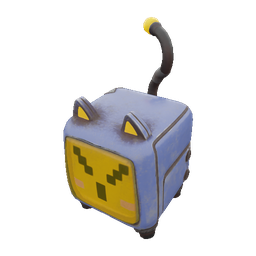

In [ ]:
# shape_id = "01_wild_hydrant"
shape_id = "27_objaverse_robocat"
example_input_path = f"./demo/demo_examples/{shape_id}.png"
example_dir = f"./exp/{shape_id}"
os.makedirs(example_dir, exist_ok=True)
input_raw = Image.open(example_input_path)
# show the input image
input_raw_copy = input_raw.copy()
input_raw_copy.thumbnail((256, 256))
input_raw_copy

SAM Time: 3.942s


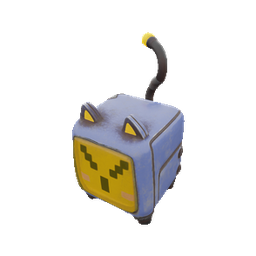

In [ ]:
# preprocess the input image
input_256 = preprocess(predictor, input_raw)
input_256

In [ ]:
# generate multi-view images in two stages with Zero123.
# first stage: generate N=8 views cover 360 degree of the input shape.
elev, stage1_imgs = stage1_run(model_zero123, device, example_dir, input_256, scale=3, ddim_steps=75)
# second stage: 4 local views for each of the first-stage view, resulting in N*4=32 source view images.
stage2_run(model_zero123, device, example_dir, elev, scale=3, stage2_steps=50)

Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 76 timesteps


DDIM Sampler: 100%|██████████| 76/76 [00:12<00:00,  6.06it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:08<00:00,  5.99it/s]
2023-12-14 01:01:11.913 | INFO     | elevation_estimate.utils.elev_est_api:get_feature_matcher:25 - Loading feature matcher...
2023-12-14 01:01:12.166 | INFO     | elevation_estimate.utils.elev_est_api:mask_out_bkgd:48 - Image has no alpha channel, using thresholding to mask out background
2023-12-14 01:01:12.171 | INFO     | elevation_estimate.utils.elev_est_api:mask_out_bkgd:48 - Image has no alpha channel, using thresholding to mask out background
2023-12-14 01:01:12.176 | INFO     | elevation_estimate.utils.elev_est_api:mask_out_bkgd:48 - Image has no alpha channel, using thresholding to mask out background
2023-12-14 01:01:12.180 | INFO     | elevation_estimate.utils.elev_est_api:mask_out_bkgd:48 - Image has no alpha channel, using thresholding to mask out background
2023-12-14 01:01:13.142 | WARNING  | elevation_estimate.utils.elev_est_api:elev_est_api:199 - K is not provided, using default K


Estimated polar angle: 60
Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 76 timesteps


DDIM Sampler: 100%|██████████| 76/76 [00:12<00:00,  5.89it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:08<00:00,  5.80it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:08<00:00,  5.71it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:08<00:00,  5.62it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:08<00:00,  5.74it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:08<00:00,  5.80it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:08<00:00,  5.83it/s]


In [ ]:
print(elev)

30


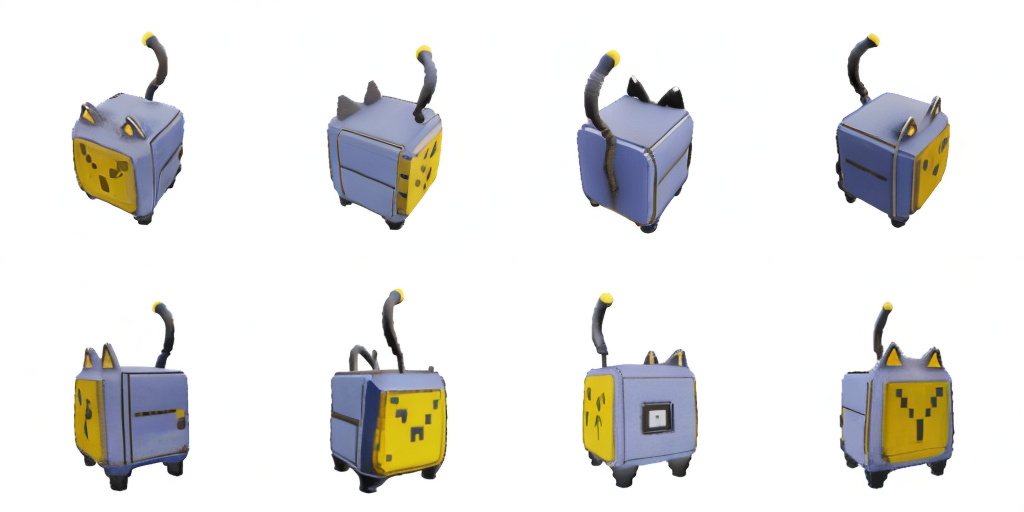

In [ ]:
image_grid(stage1_imgs, rows=2, cols=4)

In [ ]:
# utilize cost volume-based 3D reconstruction to generate textured 3D mesh
# mesh_path = reconstruct(example_dir, output_format=".glb", device_idx=_GPU_INDEX)
# print("Mesh saved to:", mesh_path)

In [ ]:
# show the textured mesh
# better viewed in MeshLab
# credit: https://github.com/google/model-viewer/issues/1088#issuecomment-612320218
# import panel as pn
# pn.extension()

# js = """
#     <script src="https://unpkg.com/@webcomponents/webcomponentsjs@2.2.7/webcomponents-loader.js"></script>
#     <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.js"></script>
#     <script nomodule src="https://unpkg.com/@google/model-viewer/dist/model-viewer-legacy.js"></script>
# """
# js_pane = pn.pane.HTML(js)

# # only .glb is supported
# html=f"""
#     <model-viewer src="./exp/{shape_id}/mesh.glb", alt="A 3D model of textured mesh generated by One-2-3-45"
#     auto-rotate camera-controls style="height:100%;width:100%;">
#     </model-viewer>
# """

# model_viewer_pane = pn.pane.HTML(html, height=800, width=500)

# app = pn.Column(js_pane, model_viewer_pane, styles={'background': 'grey'})

# app.servable()

In [ ]:
# !zip -r exp.zip exp

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

from pytorch3d.renderer import cameras

# add path for demo utils functions
import sys
import os
import cv2
sys.path.append(os.path.abspath(''))
import json

In [ ]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 8

# Get a batch of viewing angles.
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of
# the cow is facing the -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different
# viewing angles. All the cameras helper methods support mixed type inputs and
# broadcasting. So we can view the camera from the a distance of dist=2.7, and
# then specify elevation and azimuth angles for each viewpoint as tensors.
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...],
                                  T=T[None, 1, ...])

# Define the settings for rasterization and shading. Here we set the output
# image to be of size 128X128. As we are rendering images for visualization
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to
# rasterize_meshes.py for explanations of these parameters.  We also leave
# bin_size and max_faces_per_bin to their default values of None, which sets
# their values using heuristics and ensures that the faster coarse-to-fine
# rasterization method is used.  Refer to docs/notes/renderer.md for an
# explanation of the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured
# Phong shader will interpolate the texture uv coordinates for each vertex,
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

json_file_path = '/content/One-2-3-45/exp/27_objaverse_robocat/pose.json'

# Open and read the JSON file
with open(json_file_path, 'r') as file:
    # Load the JSON data as a dictionary
    poses = json.load(file)

print(poses)


target_images = []
target_cameras = []
target_silhouettes = []

folder_path = '/content/One-2-3-45/exp/27_objaverse_robocat/stage1_8'


# Check if the folder path exists
if os.path.exists(folder_path):
    # Iterate through each file in the folder
    for filename in os.listdir(folder_path):
        # Print the filename or perform any other desired action
        img = cv2.imread(folder_path + "/" + filename)
        target_images.append(img)

        e_matrix = np.array(poses['c2ws'][filename])
        swap_y_z = np.array([[1, 0, 0, 0],
                     [0, 0, -1, 0],
                     [0, -1, 0, 0],
                     [0, 0, 0, 1]])

        deg180 = np.deg2rad(180)
        rot_z = np.array([[np.cos(deg180), -np.sin(deg180), 0],
                [np.sin(deg180), np.cos(deg180), 0],
                [0, 0, 1]])

        c2w = swap_y_z @ e_matrix

        t = c2w[:3,-1]  # Extract translation of the camera
        r = c2w[:3, :3] @ rot_z # Extract rotation matrix of the camera

        t = t @ r # Make rotation local

        cameras = FoVPerspectiveCameras(R=torch.tensor([r], device=device).float(),
                                        T=torch.tensor([t], device=device).float())
        target_cameras.append(cameras)

        grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(grayscale_image, 210, 255, cv2.THRESH_BINARY)
        binary_mask = cv2.bitwise_not(binary_mask)
        target_silhouettes.append(binary_mask)


target_silhouettes = torch.tensor(target_silhouettes)
target_images = torch.tensor(target_images)
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]

print(target_images.shape)

print(target_silhouettes.shape)


# # Render the cow mesh from each viewing angle
# target_images = renderer(meshes, cameras=cameras, lights=lights)

# # Our multi-view cow dataset will be represented by these 2 lists of tensors,
# # each of length num_views.
# target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
# target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...],
#                                            T=T[None, i, ...]) for i in range(num_views)]

{'intrinsics': [[280.0, 0, 128.0], [0, 280.0, 128.0], [0, 0, 1]], 'near_far': [0.5, 1.7999999999999998], 'c2ws': {'0.png': [[0.866025447845459, -0.25, 0.4330127239227295, 0.5196152925491333], [0.5000000596046448, 0.4330126643180847, -0.75, -0.9000000357627869], [-0.0, 0.866025447845459, 0.4999999403953552, 0.5999999642372131], [0, 0, 0, 1]], '1.png': [[-0.5000000596046448, -0.43301263451576233, 0.75, 0.9000000357627869], [0.8660253882408142, -0.25, 0.43301278352737427, 0.5196153521537781], [0.0, 0.866025447845459, 0.4999999403953552, 0.5999999642372131], [0, 0, 0, 1]], '2.png': [[-0.866025447845459, 0.24999994039535522, -0.43301263451576233, -0.5196152329444885], [-0.4999999403953552, -0.4330126643180847, 0.75, 0.9000001549720764], [0.0, 0.866025447845459, 0.49999991059303284, 0.5999999642372131], [0, 0, 0, 1]], '3.png': [[0.49999991059303284, 0.4330126941204071, -0.75, -0.9000001549720764], [-0.8660255074501038, 0.24999992549419403, -0.43301257491111755, -0.5196151733398438], [0.0, 0.

/tmp/ipykernel_40314/2342607015.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  cameras = FoVPerspectiveCameras(R=torch.tensor([r], device=device).float(),


torch.Size([8, 256, 256, 3])
torch.Size([8, 256, 256])


--2023-12-14 01:02:50--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.1’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-12-14 01:02:50 (27.9 MB/s) - ‘plot_image_grid.py.1’ saved [1608/1608]



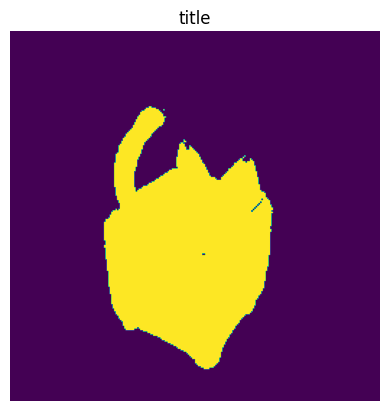

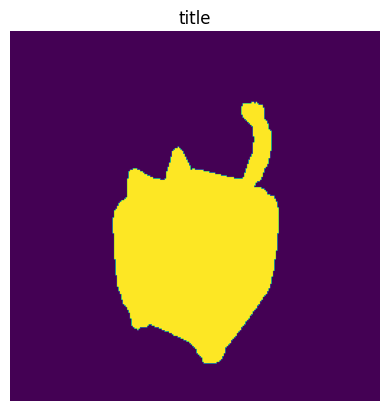

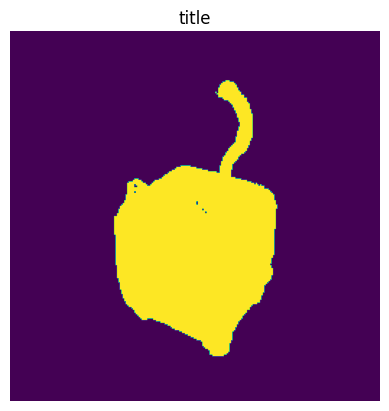

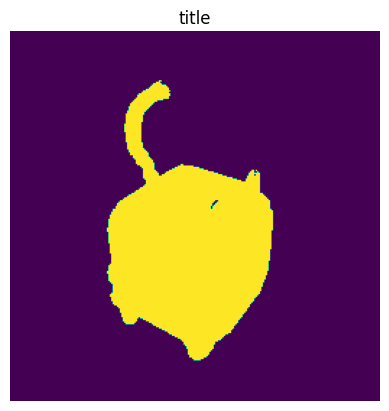

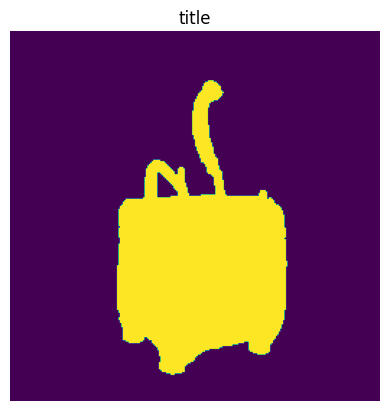

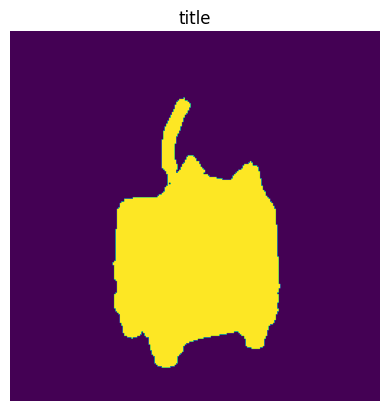

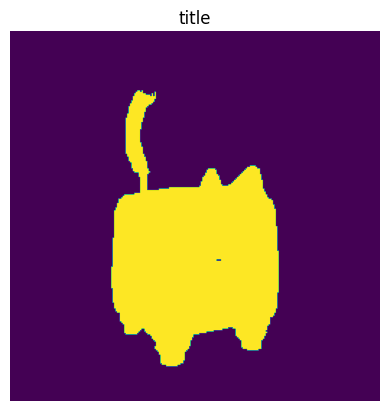

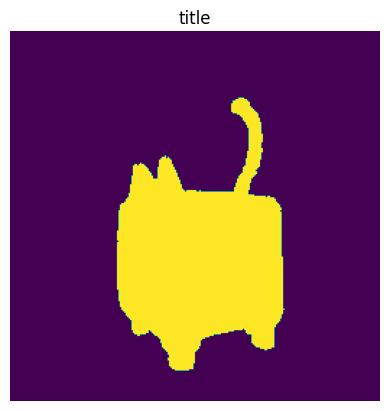

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid
# RGB images
for i in range(8):
  plt.imshow(target_silhouettes[i].cpu().detach().numpy())
  plt.title("title")
  plt.axis("off")
  plt.show()
# image_grid(target_silhouettes.cpu().numpy(), rows=2, cols=4, rgb=False)
# plt.show()

In [ ]:
#generate_alpha_channel('/content/One-2-3-45/exp/27_objaverse_robocat/stage1_8', '/content/masks')

In [ ]:
# We initialize the source shape to be a sphere of radius 1.
radius = 0.5
src_mesh = ico_sphere(4, device).scale_verts(radius)

In [ ]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 4
# Number of optimization steps
Niter = 5000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=0.1, momentum=0.9)

In [ ]:
# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

def visualize_prediction(predicted_mesh, renderer=renderer_silhouette,
                         target_image=target_rgb[1], title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class mesh_model(nn.Module):
    def __init__(self, N=10000):
        super(mesh_model, self).__init__()
        #MLP 64-64
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.bn2 = nn.BatchNorm1d(64)
        #MLP 64-1024
        self.conv3 = nn.Conv1d(64, 128, 1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 1024, 1)
        self.bn4 = nn.BatchNorm1d(1024)

        self.global_maxpool = nn.MaxPool1d(N)
        #MLP for Segmentation
        self.conv5 = nn.Conv1d(1088, 512, 1)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv6 = nn.Conv1d(512, 256, 1)
        self.bn6 = nn.BatchNorm1d(256)
        self.conv7 = nn.Conv1d(256, 128, 1)
        self.bn7 = nn.BatchNorm1d(128)
        #final conv
        self.conv8 = nn.Conv1d(128, 3, 1)

    def forward(self, points):
        '''
        points: tensor of size (B, N, 3)
                , where B is batch size and N is the number of points per object (N=10000 by default)
        output: tensor of size (B, N, num_seg_classes)
        '''
        N=points.shape[1]
        # Permute the input to (B, 3, N)
        x = points.permute(0, 2, 1).cuda()

        # print(f"x_input_permuted : {x.shape}")

        #MLP 64-64
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x)))
        local_feat=x
        #MLP 64-1024
        x=F.relu(self.bn3(self.conv3(x)))
        x=F.relu(self.bn4(self.conv4(x)))

        #Global max pooling
        # print(f"x_before_max_pool : {x.shape}")
        # x=self.global_maxpool(x).squeeze() # Bx1088
        x, _ = torch.max(x,dim=-1)

        # print(f"x_after_max_pool : {x.shape}")

        global_feat=x
        global_feat=global_feat.repeat(1,N).view(-1,N,global_feat.shape[1])
        local_feat=local_feat.permute(0,2,1)

        #Concatenate global features with local features
        # print(global_feat.shape,local_feat.shape)
        x=torch.cat((local_feat,global_feat),dim=-1).permute(0,2,1)
        # print(x.shape)

        #MLP for Segmentation
        x=F.relu(self.bn5(self.conv5(x)))
        x=F.relu(self.bn6(self.conv6(x)))
        x=F.relu(self.bn7(self.conv7(x)))
        #Final conv
        x=self.conv8(x)
        # print(x.shape)
        x=x.permute(0,2,1)

        return x

model = mesh_model(verts_shape).to(device)

In [ ]:
from tqdm import tqdm

if __name__ == '__main__':
    data = range(10000)
    for i, item in enumerate(tqdm(range(len(data)))):
        i = i + 1

100%|██████████| 10000/10000 [00:00<00:00, 1575147.96it/s]


In [ ]:
loop = tqdm(range(Niter))
# Optimizer
opt = optim.Adam(model.parameters(), lr = 0.01, betas=(0.9, 0.999))
model.train()
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
init_verts = src_mesh.verts_packed()

for i in loop:
    opt.zero_grad()

    deform_verts = model(init_verts.unsqueeze(0))

    # Deform the mesh
    # new_src_mesh = src_mesh.offset_verts(deform_verts)
    new_src_mesh = src_mesh.offset_verts(deform_verts.squeeze(0)).cuda()

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Compute the average silhouette loss over two random views, as the average
    # squared L2 distance between the predicted silhouette and the target
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j].cuda(), lights=lights.cuda())
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouettes[j].cuda()) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))


    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
                             target_image=target_silhouettes[1])

    # Optimization step
    sum_loss.backward()
    opt.step()



In [ ]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device,
        cameras=camera,
        lights=lights)
)

In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 100

%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
#optimizer = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=0.01, momentum=0.9)
optimizer = torch.optim.SGD([deform_verts], lr=0.0001, momentum=0.9)

--2023-12-14 01:13:48--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/camera_visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2037 (2.0K) [text/plain]
Saving to: ‘camera_visualization.py.1’

camera_visualizatio 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-12-14 01:13:48 (30.9 MB/s) - ‘camera_visualization.py.1’ saved [2037/2037]



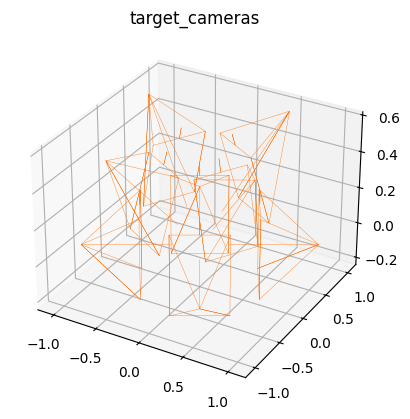

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/camera_visualization.py
from camera_visualization import plot_camera_scene, plot_cameras

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.clear()
ax.set_title("target_cameras")
for i in range(len(target_cameras)):
  handle_cam = plot_cameras(ax, target_cameras[i].to(device), color="#FF7D1E")
plt.show()



In [ ]:
import imageio
from pytorch3d.renderer import (
    AlphaCompositor,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    HardPhongShader,
)
import pytorch3d

def get_mesh_renderer(image_size=512, lights=None, device=None):
    """
    Returns a Pytorch3D Mesh Renderer.

    Args:
        image_size (int): The rendered image size.
        lights: A default Pytorch3D lights object.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = RasterizationSettings(
        image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(raster_settings=raster_settings),
        shader=HardPhongShader(device=device, lights=lights),
    )
    return renderer

In [ ]:
def render_mesh(mesh_input, camera, device):
    # Get the renderer.
    renderer = get_mesh_renderer(image_size=256)
    vertices = mesh_input.verts_list()[0]
    faces = mesh_input.faces_list()[0]
    vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    textures = torch.ones_like(vertices).to(device)  # (1, N_v, 3)
    textures = textures * torch.tensor([0.7, 0.7, 1]).to(device)  # (1, N_v, 3)
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)

    # Get the vertices, faces, and textures.
    view_angles = np.linspace(0, 360, 48, endpoint=False)

    my_images = []

    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
    rend = renderer(mesh, cameras=camera, lights=lights)
    rend = rend.cpu().numpy()[0, ..., :3]

    image = Image.fromarray((rend * 255).astype(np.uint8))

    return image

In [ ]:
for i in range(len(target_cameras)):
  images_predicted = render_mesh(src_mesh, camera=target_cameras[i].to(device), device=device)
  plt.imshow(images_predicted)
  plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class HarmonicEmbedding(torch.nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        n_harmonic_functions: int = 6,
        omega0: float = 1.0,
        logspace: bool = True,
        include_input: bool = True,
    ) -> None:
        super().__init__()

        if logspace:
            frequencies = 2.0 ** torch.arange(
                n_harmonic_functions,
                dtype=torch.float32,
            )
        else:
            frequencies = torch.linspace(
                1.0,
                2.0 ** (n_harmonic_functions - 1),
                n_harmonic_functions,
                dtype=torch.float32,
            )

        self.register_buffer("_frequencies", omega0 * frequencies, persistent=False)
        self.include_input = include_input
        self.output_dim = n_harmonic_functions * 2 * in_channels

        if self.include_input:
            self.output_dim += in_channels

    def forward(self, x: torch.Tensor):
        embed = (x[..., None] * self._frequencies).view(*x.shape[:-1], -1)

        if self.include_input:
            return torch.cat((embed.sin(), embed.cos(), x), dim=-1)
        else:
            return torch.cat((embed.sin(), embed.cos()), dim=-1)

In [ ]:
class mesh_model(nn.Module):
    def __init__(self, N=10000):
        super(mesh_model, self).__init__()
        #MLP 64-64
        self.conv1 = nn.Conv1d(39, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.bn2 = nn.BatchNorm1d(64)
        #MLP 64-1024
        self.conv3 = nn.Conv1d(64, 128, 1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 1024, 1)
        self.bn4 = nn.BatchNorm1d(1024)

        self.global_maxpool = nn.MaxPool1d(N)
        #MLP for Segmentation
        self.conv5 = nn.Conv1d(1088, 512, 1)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv6 = nn.Conv1d(512, 256, 1)
        self.bn6 = nn.BatchNorm1d(256)
        self.conv7 = nn.Conv1d(256, 128, 1)
        self.bn7 = nn.BatchNorm1d(128)
        #final conv
        self.conv8 = nn.Conv1d(128, 6, 1)

    def forward(self, points):
        '''
        points: tensor of size (B, N, 3)
                , where B is batch size and N is the number of points per object (N=10000 by default)
        output: tensor of size (B, N, num_seg_classes)
        '''
        N=points.shape[1]
        # Permute the input to (B, 3, N)
        x = points.permute(0, 2, 1).cuda()

        # print(f"x_input_permuted : {x.shape}")

        #MLP 64-64
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x)))
        local_feat=x
        #MLP 64-1024
        x=F.relu(self.bn3(self.conv3(x)))
        x=F.relu(self.bn4(self.conv4(x)))

        #Global max pooling
        # print(f"x_before_max_pool : {x.shape}")
        # x=self.global_maxpool(x).squeeze() # Bx1088
        x, _ = torch.max(x,dim=-1)

        # print(f"x_after_max_pool : {x.shape}")

        global_feat=x
        global_feat=global_feat.repeat(1,N).view(-1,N,global_feat.shape[1])
        local_feat=local_feat.permute(0,2,1)

        #Concatenate global features with local features
        # print(global_feat.shape,local_feat.shape)
        x=torch.cat((local_feat,global_feat),dim=-1).permute(0,2,1)
        # print(x.shape)

        #MLP for Segmentation
        x=F.relu(self.bn5(self.conv5(x)))
        x=F.relu(self.bn6(self.conv6(x)))
        x=F.relu(self.bn7(self.conv7(x)))
        #Final conv
        x=self.conv8(x)
        print(x.shape)

        x=x.permute(0,2,1)

        return x

model = mesh_model(verts_shape).to(device)

In [ ]:
loop = tqdm(range(Niter))
# Optimizer
opt = optim.Adam(model.parameters(), lr = 0.01, betas=(0.9, 0.999))
harmonic_embedding_xyz = HarmonicEmbedding()
model.train()
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=1.0, momentum=0.9)

for i in loop:
    # Initialize optimizer
    opt.zero_grad()

    map = harmonic_embedding_xyz(init_verts.cpu())

    predict = model(map.unsqueeze(0))

    # Deform the mesh
    # new_src_mesh = src_mesh.offset_verts(deform_verts)
    new_src_mesh = src_mesh.offset_verts(predict[:, :, :3].squeeze(0))


    # Add per vertex colors to texture the mesh
    # new_src_mesh.textures = TexturesVertex(verts_features=torch.clamp(predict[:, :, 3:], 0, 255))

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted silhouette and the target
        # silhouette from our dataset
        predicted_silhouette = images_predicted[..., 3]

        loss_silhouette = ((predicted_silhouette.cuda() - target_silhouettes[j].cuda()) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

        # Squared L2 distance between the predicted RGB image and the target
        # image from our dataset
        # predicted_rgb = images_predicted[..., :3]
        # loss_rgb = ((predicted_rgb.cuda() - target_rgb[j].cuda()) ** 2).mean()
        # loss["rgb"] += loss_rgb / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_silhouette, title="iter: %d" % i, silhouette=True)

    # Optimization step
    sum_loss.backward()
    opt.step()

In [ ]:
print(new_src_mesh)
visualize_prediction(new_src_mesh, renderer=renderer_textured, silhouette=False)

#trying to branch


In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 4
# Number of optimization steps
Niter = 5000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
          "rgb": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=0.1, momentum=0.9)

In [ ]:
class HarmonicEmbedding(torch.nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        n_harmonic_functions: int = 6,
        omega0: float = 1.0,
        logspace: bool = True,
        include_input: bool = True,
    ) -> None:
        super().__init__()

        if logspace:
            frequencies = 2.0 ** torch.arange(
                n_harmonic_functions,
                dtype=torch.float32,
            )
        else:
            frequencies = torch.linspace(
                1.0,
                2.0 ** (n_harmonic_functions - 1),
                n_harmonic_functions,
                dtype=torch.float32,
            )

        self.register_buffer("_frequencies", omega0 * frequencies, persistent=False)
        self.include_input = include_input
        self.output_dim = n_harmonic_functions * 2 * in_channels

        if self.include_input:
            self.output_dim += in_channels

    def forward(self, x: torch.Tensor):
        embed = (x[..., None] * self._frequencies).view(*x.shape[:-1], -1)

        if self.include_input:
            return torch.cat((embed.sin(), embed.cos(), x), dim=-1)
        else:
            return torch.cat((embed.sin(), embed.cos()), dim=-1)

In [ ]:
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette,
                         target_image=target_rgb[1], title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class mesh_model(nn.Module):
    def __init__(self, N=10000, target_image_size=(256, 256)):
        super(mesh_model, self).__init__()
        # Initial MLP layers
        self.conv1 = nn.Conv1d(39, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.bn2 = nn.BatchNorm1d(64)

        # Second set of MLP layers
        self.conv3 = nn.Conv1d(64, 128, 1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 1024, 1)
        self.bn4 = nn.BatchNorm1d(1024)

        self.global_maxpool = nn.MaxPool1d(N)

        # Shared MLP layers for both branches
        self.conv5 = nn.Conv1d(1088, 512, 1)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv6 = nn.Conv1d(512, 256, 1)
        self.bn6 = nn.BatchNorm1d(256)
        self.conv7 = nn.Conv1d(256, 128, 1)
        self.bn7 = nn.BatchNorm1d(128)

        # Branch for vertex coordinates
        self.conv_vertex = nn.Conv1d(128, 3, 1)  # 3 output channels for coordinates

        # Branch for RGB prediction
        self.conv_rgb = nn.Conv1d(128, target_image_size[0] * target_image_size[1], 1)  # 3 output channels for RGB
        self.sigmoid = nn.Sigmoid()


    def forward(self, points):
        N = points.shape[1]
        x = points.permute(0, 2, 1).cuda()

        # Initial layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_feat = x

        # Second set of layers
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        # Global max pooling
        x, _ = torch.max(x, dim=-1)

        global_feat = x
        global_feat = global_feat.repeat(1, N).view(-1, N, global_feat.shape[1])
        local_feat = local_feat.permute(0, 2, 1)

        # Concatenate global and local features
        x = torch.cat((local_feat, global_feat), dim=-1).permute(0, 2, 1)

        # Shared MLP layers
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))

        # Branch out to vertex coordinates and RGB
        vertex_out = self.conv_vertex(x).permute(0, 2, 1)  # Shape: (B, N, 3)
        rgb_out = self.sigmoid(self.conv_rgb(x))
        rgb_out = rgb_out.permute(0, 2, 1)  # Shape: (B, 256*256, 3)
        rgb_out = rgb_out.reshape(-1, 256, 256, 3)

        return vertex_out, rgb_out
model = mesh_model(verts_shape).to(device)

In [ ]:
# from pytorch3d.structures import TexturesVertex

loop = tqdm(range(Niter))
# Optimizer
opt = optim.Adam(model.parameters(), lr = 0.01, betas=(0.9, 0.999))
harmonic_embedding_xyz = HarmonicEmbedding()
model.train()
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
init_verts = src_mesh.verts_packed()

# We will also learn per vertex colors for our sphere mesh that define texture
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=1.0, momentum=0.9)

for i in loop:
    # Initialize optimizer
    opt.zero_grad()

    map = harmonic_embedding_xyz(init_verts.cpu())

    vertex_predict, rgb_predict = model(map.unsqueeze(0))

    # Deform the mesh
    # new_src_mesh = src_mesh.offset_verts(deform_verts)
    new_src_mesh = src_mesh.offset_verts(vertex_predict.squeeze(0))

    # Add per vertex colors to texture the mesh
    # new_src_mesh.textures = TexturesVertex(verts_features=torch.clamp(rgb_predict.squeeze(0), 0, 1))

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted silhouette and the target
        # silhouette from our dataset
        predicted_silhouette = images_predicted[..., 3]

        loss_silhouette = ((predicted_silhouette.cuda() - target_silhouettes[j].cuda()) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

        # Squared L2 distance between the predicted RGB image and the target
        # image from our dataset
        predicted_rgb = rgb_predict
        print(f"Shape of predicted_rgb: {predicted_rgb.shape}")
        print(f"Shape of target_rgb[{j}]: {target_rgb[j].shape}")
        loss_rgb = ((predicted_rgb.cuda() - target_rgb[j].cuda()) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_silhouette, title="iter: %d" % i, silhouette=True)

    # Optimization step
    sum_loss.backward()
    opt.step()

  0%|          | 0/2000 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
torch.cuda.empty_cache()


In [ ]:
class VertexModel(nn.Module):
    def __init__(self, N=10000):
        super(VertexModel, self).__init__()
        # Initial MLP layers from your original model
        self.conv1 = nn.Conv1d(39, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.bn2 = nn.BatchNorm1d(64)

        # Second set of MLP layers
        self.conv3 = nn.Conv1d(64, 128, 1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 1024, 1)
        self.bn4 = nn.BatchNorm1d(1024)

        self.global_maxpool = nn.MaxPool1d(N)

        # Shared MLP layers for the vertex branch
        self.conv5 = nn.Conv1d(1088, 512, 1)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv6 = nn.Conv1d(512, 256, 1)
        self.bn6 = nn.BatchNorm1d(256)
        self.conv7 = nn.Conv1d(256, 128, 1)
        self.bn7 = nn.BatchNorm1d(128)

        # Vertex branch
        self.conv_vertex = nn.Conv1d(128, 3, 1)  # 3 output channels for coordinates

    def forward(self, points):
        N = points.shape[1]
        x = points.permute(0, 2, 1).cuda()

        # Initial layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_feat = x

        # Second set of layers
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        # Global max pooling
        x, _ = torch.max(x, dim=-1)

        global_feat = x
        global_feat = global_feat.repeat(1, N).view(-1, N, global_feat.shape[1])
        local_feat = local_feat.permute(0, 2, 1)

        # Concatenate global and local features
        x = torch.cat((local_feat, global_feat), dim=-1).permute(0, 2, 1)

        # Shared MLP layers
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))

        # Branch out to vertex coordinates and RGB
        vertex_out = self.conv_vertex(x).permute(0, 2, 1)
        return vertex_out


In [ ]:
class RGBModel(nn.Module):
    def __init__(self, N = 10000, target_image_size=(256, 256)):
        super(RGBModel, self).__init__()
        # Initial MLP layers from your original model
        self.conv1 = nn.Conv1d(39, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.bn2 = nn.BatchNorm1d(64)

        # Second set of MLP layers
        self.conv3 = nn.Conv1d(64, 128, 1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 1024, 1)
        self.bn4 = nn.BatchNorm1d(1024)

        self.global_maxpool = nn.MaxPool1d(N)

        # Shared MLP layers for the vertex branch
        self.conv5 = nn.Conv1d(1088, 512, 1)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv6 = nn.Conv1d(512, 256, 1)
        self.bn6 = nn.BatchNorm1d(256)
        self.conv7 = nn.Conv1d(256, 128, 1)
        self.bn7 = nn.BatchNorm1d(128)

        # RGB branch
        self.conv_rgb = nn.Conv1d(128, target_image_size[0] * target_image_size[1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, points):
        N = points.shape[1]
        x = points.permute(0, 2, 1).cuda()

        # Initial layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_feat = x

        # Second set of layers
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        # Global max pooling
        x, _ = torch.max(x, dim=-1)

        global_feat = x
        global_feat = global_feat.repeat(1, N).view(-1, N, global_feat.shape[1])
        local_feat = local_feat.permute(0, 2, 1)

        # Concatenate global and local features
        x = torch.cat((local_feat, global_feat), dim=-1).permute(0, 2, 1)

        # Shared MLP layers
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))

        rgb_out = self.sigmoid(self.conv_rgb(x))
        rgb_out = rgb_out.view(-1, 3, 256, 256)  # Shape: (B, 3, 256, 256)
        rgb_out = rgb_out.permute(0, 2, 3, 1)  # Shape: (B, 256, 256, 3)
        return rgb_out


In [ ]:
# from pytorch3d.structures import TexturesVertex

# Initialize models
vertex_model = VertexModel().to(device)
rgb_model = RGBModel().to(device)

# Initialize optimizers
optimizer_vertex = torch.optim.Adam(vertex_model.parameters(), lr=0.01)
optimizer_rgb = torch.optim.Adam(rgb_model.parameters(), lr=0.01)

# Loop
loop = tqdm(range(Niter))
vertex_model.train()
rgb_model.train()
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
init_verts = src_mesh.verts_packed()
for i in loop:
    optimizer_vertex.zero_grad()
    optimizer_rgb.zero_grad()

    # Harmonic embedding and input preparation
    map = harmonic_embedding_xyz(init_verts.cpu())
    vertex_predict = vertex_model(map.unsqueeze(0))
    rgb_predict = rgb_model(map.unsqueeze(0))
    print(vertex_predict.shape)
    print(rgb_predict.shape)

    # Mesh deformation and texture application
    new_src_mesh = src_mesh.offset_verts(vertex_predict.squeeze(0))
    # new_src_mesh.textures = TexturesVertex(verts_features=torch.clamp(rgb_predict.squeeze(0), 0, 1))

    # Loss calculation
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Iterating over views for loss calculation
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        print(images_predicted.shape)
        predicted_silhouette = images_predicted[..., 3]

        loss_silhouette = ((predicted_silhouette.cuda() - target_silhouettes[j].cuda()) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

        loss_rgb = ((rgb_predict.cuda() - target_rgb[j].cuda()) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration

    # Sum and backpropagate losses
    sum_loss_vertex = sum(loss[k] * losses[k]["weight"] for k in loss if k != 'rgb')
    sum_loss_rgb = sum(loss[k] * losses[k]["weight"] for k in loss if k == 'rgb')

    sum_loss_vertex.backward()
    optimizer_vertex.step()

    sum_loss_rgb.backward()
    optimizer_rgb.step()

    # Update loop description
    loop.set_description("total_loss = %.6f" % (sum_loss_vertex.item() + sum_loss_rgb.item()))

    # Visualization and other tasks
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_silhouette, title="iter: %d" % i, silhouette=True)


  0%|          | 0/2000 [00:00<?, ?it/s]


OutOfMemoryError: ignored